<a href="https://colab.research.google.com/github/murmayasa/murmayasa/blob/main/model_klasifikasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import tensorflow as tf
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import random
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, classification_report
from sklearn.utils import shuffle
keras.optimizers.Adam

keras.optimizers.adam.Adam

# Mengakses Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
base_dir = '/content/drive/My Drive/SEMINAR_MURMAYASA 19101032/Projek/dataset/dataset 1'
!ls "/content/drive/My Drive/SEMINAR_MURMAYASA 19101032/Projek/dataset/dataset 1"

dataset_files = os.listdir(base_dir)
class_counts = []
class_labels = []

for class_dir in dataset_files:
    class_path = os.path.join(base_dir, class_dir)
    if os.path.isdir(class_path):
        class_count = len(os.listdir(class_path))
        class_counts.append(class_count)
        class_labels.append(class_dir)

data = {'Kelas': class_labels, 'Jumlah Data': class_counts}
df = pd.DataFrame(data)
print(df)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
cataract  normal
      Kelas  Jumlah Data
0  cataract         1038
1    normal         1074


# Menampilkan jumlah dataset

Jumlah data setiap kelas
Jumlah dataset Cataract :  516
Jumlah dataset Normal :  523


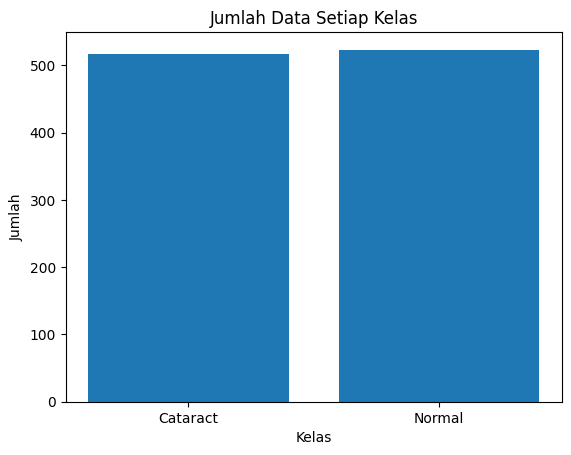

      Kelas  Jumlah Data
0  Cataract          516
1    Normal          523


In [ ]:
cataract_dir = os.path.join(base_dir, 'cataract/')
normal_dir = os.path.join(base_dir, 'normal/')

print("Jumlah data setiap kelas")
print('Jumlah dataset Cataract : ',len(os.listdir(cataract_dir)))
print('Jumlah dataset Normal : ',len(os.listdir(normal_dir)))
num_cataract = len(os.listdir(cataract_dir))
num_normal = len(os.listdir(normal_dir))

# Menampilkan diagram jumlah
labels = ['Cataract', 'Normal']
values = [num_cataract, num_normal]

plt.bar(labels, values)
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.title('Jumlah Data Setiap Kelas')
plt.show()

# Menggabungkan dataset

In [ ]:
dataset_dir = os.path.join(base_dir, 'dataset')
train_dir = os.path.join(base_dir, 'latih')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validasi')

# Split Dataset

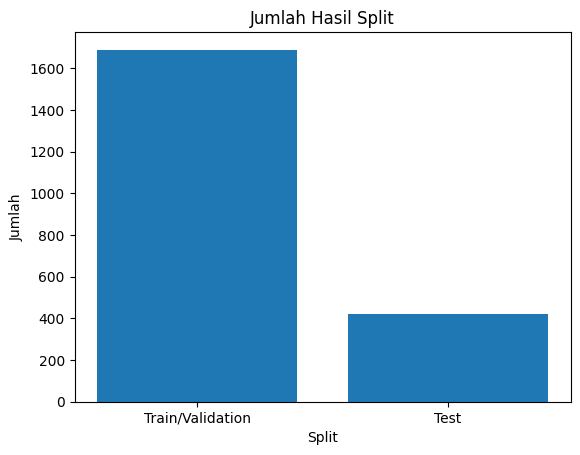

In [ ]:
image_paths = []
labels = []
for label, label_dir in enumerate([cataract_dir, normal_dir]):
    for filename in os.listdir(label_dir):
        image_paths.append(os.path.join(label_dir, filename))
        labels.append(label)

train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

num_train_val = len(train_val_paths)
num_test = len(test_paths)

# Menampilkan diagram jumlah split
labels = ['Train/Validation', 'Test']
values = [num_train_val, num_test]
plt.bar(labels, values)
plt.xlabel('Split')
plt.ylabel('Jumlah')
plt.title('Jumlah Hasil Split')
plt.show()

def my_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_Score = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1_Score))
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1_Score

# Pembuatan Model

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(2, activation='softmax'),
])

# Compile

In [ ]:
learning_rate = 0.001
model.compile(loss='categorical_crossentropy',
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 64)        0

# Training Model

In [ ]:
class_labels = [cataract_dir, normal_dir]
skf = StratifiedKFold(n_splits=2, shuffle=True)

fold_num = 0
test_losses = []
test_accuracies = []
confusion_matrices = []

for train_index, val_index in skf.split(train_val_paths, train_val_labels):
    fold_num += 1
    print("Results for fold : ", fold_num)
    X_train, X_val = np.array(train_val_paths)[train_index], np.array(train_val_paths)[val_index]
    Y_train, Y_val = np.array(train_val_labels)[train_index], np.array(train_val_labels)[val_index]
    
    for each_index in range(len(X_val)):
        class_label = ''
        for i in range(len(class_labels)):
            if Y_val[each_index] == str(i):
                class_label = class_labels[i]
        shutil.move(
            os.path.join(base_dir, 'latih', class_label, X_val[each_index]),
            os.path.join(base_dir, 'validasi', class_label, X_val[each_index])
        )

    train_datagen = ImageDataGenerator(
        rescale=1./225,
        brightness_range=[0.5, 1.0],
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        height_shift_range=0.1,
        width_shift_range=0.1,
        rotation_range=45,
        fill_mode='wrap',
    )

    train_val_generators = []
    for train_indices, val_indices in skf.split(train_val_paths, train_val_labels):
        train_paths = [train_val_paths[i] for i in train_indices]
        val_paths = [train_val_paths[i] for i in val_indices]
        train_labels = [train_val_labels[i] for i in train_indices]
        val_labels = [train_val_labels[i] for i in val_indices]
        train_labels = [str(label) for label in train_labels]
        val_labels = [str(label) for label in val_labels]
        
        train_generator = train_datagen.flow_from_dataframe(
            pd.DataFrame({"image_path": train_paths, "label": train_labels}),
            x_col="image_path",
            y_col="label",
            target_size=(100, 150),
            batch_size=32,
            class_mode="categorical",
            subset="training"
        )
        
        val_generator = train_datagen.flow_from_dataframe(
            pd.DataFrame({"image_path": val_paths, "label": val_labels}),
            x_col="image_path",
            y_col="label",
            target_size=(100, 150),
            batch_size=32,
            class_mode="categorical",
        )
        
        train_val_generators.append((train_generator, val_generator))
        # Training Model
        history = model.fit(
            train_generator,
            epochs=15,
            steps_per_epoch=len(train_generator),
            validation_data=val_generator,
            validation_steps=len(val_generator),
            verbose=2
        )
    predictions = model.predict(val_generator, verbose=1)
    y_predictions = np.argmax(predictions, axis=1)
    true_classes = val_generator.classes
    
    # evaluate validation performance
    print("***Performance on Validation data***")
    val_acc, val_prec, val_fScore = my_metrics(true_classes, y_predictions)

# Report Hasil Training

In [ ]:
print("*** Classification Report ***")
clr = classification_report(true_classes, y_predictions, target_names=['cataract', 'normal'])
print(clr)

*** Classification Report ***
              precision    recall  f1-score   support

    cataract       0.43      0.38      0.40        82
      normal       0.46      0.51      0.48        84

    accuracy                           0.45       166
   macro avg       0.44      0.44      0.44       166
weighted avg       0.44      0.45      0.44       166



#Testing Model

In [ ]:
class_labels = [cataract_dir, normal_dir]
skf = StratifiedKFold(n_splits=5, shuffle=True)

fold_num = 0
test_losses = []
test_accuracies = []
confusion_matrices = []

for train_index, test_index in skf.split(train_val_paths, train_val_labels):
    fold_num += 1
    print("Results for fold : ", fold_num)
    X_train, X_test = np.array(train_val_paths)[train_index], np.array(train_val_paths)[test_index]
    Y_train, Y_test = np.array(train_val_labels)[train_index], np.array(train_val_labels)[test_index]

    for each_index in range(len(X_test)):
        class_label = ''
        for i in range(len(class_labels)):
            if Y_test[each_index] == str(i):
                class_label = class_labels[i]
        shutil.move(
            os.path.join(base_dir, 'latih', class_label, X_test[each_index]),
            os.path.join(base_dir, 'test', class_label, X_test[each_index])
        )

    test_datagen = ImageDataGenerator(rescale=1./225)
    test_labels = [str(label) for label in Y_test]

    test_generator = test_datagen.flow_from_dataframe(
        pd.DataFrame({'image_path': X_test, 'label': test_labels}),
        x_col='image_path',
        y_col='label',
        target_size=(100, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    test_loss, test_acc = model.evaluate(
        test_generator,
        steps=len(test_generator),
        verbose=1
    )

    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    predictions = model.predict(test_generator, verbose=1)
    y_predictions = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes

    # evaluate validation performance
    print("*** Performance on Validation data ***")
    val_acc, val_prec, val_fScore = my_metrics(true_classes, y_predictions)
    confusion_matrices.append(confusion_matrix(true_classes, y_predictions))

Results for fold :  1
Found 167 validated image filenames belonging to 2 classes.
6/6 [==============================] - 5s 796ms/step
*** Performance on Validation data ***
Accuracy  : 0.8263473053892215
Precision : 0.830074811144929
f1Score : 0.8257848978713198
[[64 19]
 [10 74]]
Results for fold :  2
Found 166 validated image filenames belonging to 2 classes.
6/6 [==============================] - 3s 518ms/step
*** Performance on Validation data ***
Accuracy  : 0.8373493975903614
Precision : 0.8385780885780886
f1Score : 0.8372016999019287
[[67 16]
 [11 72]]
Results for fold :  3
Found 166 validated image filenames belonging to 2 classes.
6/6 [==============================] - 3s 515ms/step
*** Performance on Validation data ***
Accuracy  : 0.8373493975903614
Precision : 0.8377906976744186
f1Score : 0.8372962573056958
[[68 15]
 [12 71]]
Results for fold :  4
Found 166 validated image filenames belonging to 2 classes.
6/6 [==============================] - 3s 532ms/step
*** Performanc

# Report Hasil Testing

In [ ]:
print("*** Classification Report ***")
clr = classification_report(true_classes, y_predictions, target_names=['cataract', 'normal'])
print(clr)

*** Classification Report ***
              precision    recall  f1-score   support

    cataract       0.79      0.71      0.75        82
      normal       0.74      0.82      0.78        84

    accuracy                           0.77       166
   macro avg       0.77      0.76      0.76       166
weighted avg       0.77      0.77      0.76       166

